# Práctica 2: Procesamiento del Lenguaje Natural

__Fecha de entrega: 17 de abril de 2022__

El objetivo de esta práctica es aplicar los conceptos teóricos vistos en clase en el módulo de PLN. La práctica consta de 2 notebooks que se entregarán simultáneamente en la tarea de entrega habilitada en el Campus  Virtual.

Lo más importante en esta práctica no es el código Python, sino el análisis de los datos y modelos que construyas y las explicaciones razonadas de cada una de las decisiones que tomes. __No se valorarán trozos de código o gráficas sin ningún tipo de contexto o explicación__.

Finalmente, recuerda establecer el parámetro `random_state` en todas las funciones que tomen decisiones aleatorias para que los resultados sean reproducibles (los resultados no varíen entre ejecuciones).

In [4]:
RANDOM_STATE = 333

# Apartado 1: Clasificador de noticias

__Número de grupo: 11__

__Nombres de los estudiantes: Aitor Esteban y Edurne Ruiz__

## 1) Carga del conjunto de datos

El fichero `BBC News.csv` contiene noticias clasificadas en 5 categorías diferentes. 

Carga los datos en un dataframe teniendo en cuenta que la columna `ArticleId` es un identificador de la noticia y por lo tanto no debes usarlo para clasificar. 

Estudia el tamaño del conjunto de datos y la proporción de noticias que pertenecen a cada una de las categorías. Indica si debemos tenerlo en cuenta de alguna forma al analizar los modelos que construyamos.

Muestra un mensaje cualquiera y explica si lo habrías clasificado en la clase correcta tras leerlo.

Crea una partición de los datos dejando el 80% para entrenamiento y el 20% restante para test usando la función `train_test_split` de sklearn. 

In [5]:
import numpy as np
import pandas as pd

In [6]:
df = pd.read_csv('BBC News.csv')
df = df.drop(['ArticleId'], axis = 1)
df

,Text,Category
0,worldcom ex-boss launches defence lawyers defe...,business
1,german business confidence slides german busin...,business
2,bbc poll indicates economic gloom citizens in ...,business
3,lifestyle governs mobile choice faster bett...,tech
4,enron bosses in $168m payout eighteen former e...,business
...,...,...
1485,double eviction from big brother model caprice...,entertainment
1486,dj double act revamp chart show dj duo jk and ...,entertainment
1487,weak dollar hits reuters revenues at media gro...,business
1488,apple ipod family expands market apple has exp...,tech


In [7]:
df['Category'].value_counts()

sport            346
business         336
politics         274
entertainment    273
tech             261
Name: Category, dtype: int64

<AxesSubplot:ylabel='Category'>

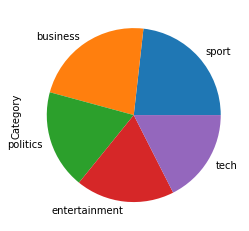

In [8]:
# Diagrama mostrando las categorias
df['Category'].value_counts().plot.pie()

Vemos que contamos con 1490 noticias sobre cinco grandes temas: deportes, negocios, política, entretenimiento y tecnología. Los temas están más o menos repartidos equitativamente, aunque hay ligeramente mayor cantidad de noticias de deportes y negocios. Esto va a ser importante para analizar el modelo que construyamos, pues va a relacionar las 'palabras clave' que encuentre en cada texto con su tema correspondiente. Cuánto mayor sea el número de noticias, más refinado debería ser el modelo, aunque podría fallar al añadir noticias que relacionen más de un tema y que fueran difíciles de clasificar. 

Ahora, elegimos una noticia al azar entre las tantas propuestas:

In [9]:
df.values[23][0]

'ferguson urges henry punishment sir alex ferguson has called on the football association to punish arsenal s thierry henry for an incident involving gabriel heinze.  ferguson believes henry deliberately caught heinze on the head with his knee during united s controversial win. the united boss said it was worse than ruud van nistelrooy s foul on ashley cole for which he got a three-game ban.  we shall present it to the fa and see what they do. the tackle on heinze was terrible   he said. clubs are permitted to ask the fa to examine specific incidents but information is expected to be provided within 48 hours of the game. the clash occurred moments before half-time when a freddie ljungberg challenge left heinze on the ground on the left touchline. henry  following the ball  attempted to hurdle the argentine but his knee collided with the back of heinze s head.  the striker protested his innocence - and referee mike riley deemed the collision accidental. ferguson was also upset by arsena

Si analizamos el siguiente texto podemos podemos obsevar que es se trata de una noticia sobre un acontecimiento en un partido de fútbol entre los equipos Arsenal y Manchester United. Se narra la controversia que hubo a raíz de una falta cometida por un jugador. Por tanto podemos clasificarlo como una noticia deportiva fijandonos en el tema y en las palabras clave utilizadas como 'football, game, defeat, arsenal, fouls, referee...'

In [10]:
df.values[23][1]

'sport'

Como habíamos supuesto en el apartado anterior, el texto está correctamente clasificado como deportivo. 

Por último, realizamos una partición de los datos, de forma que el 80% de ellos se usen como datos de entrenamiento y el 20% restante, como datos de test. 

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
train_data , test_data = train_test_split(df, train_size = 0.8, random_state = RANDOM_STATE)
len(train_data), len(test_data)

(1192, 298)

## 2) Representación basada en bolsa de palabras y frecuencia de aparición

La primera vectorización que vamos a usar representará los mensajes usando el modelo de bolsa de palabras, monogramas y la frecuencia de aparición de cada palabra. Usa como _stop words_ las que vienen configuradas por defecto para el inglés.

Aplica la vectorización a los conjuntos de mensajes de entrenamiento y test. Muestra algún mensaje tanto en su formato de texto original como en la versión vectorizada. ¿Qué palabras se han eliminado y por qué?

Entrena un clasificador Naive Bayes Multinomial y calcula su tasa de aciertos sobre el conjunto de entrenamiento y el conjunto de test. A continuación calcula los valores de precisión, exhaustividad y puntuación F1 para cada una de las clases. Dibuja la matriz de confusión. Analiza los resultados obtenidos.

A continuación, entrena un clasificador k-NN con la configuración por defecto y usando la misma vectorización. Analiza los resultados, ¿a qué crees que se deben?

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

El primer paso es obtener las frecuencias de las palabras y lo haremos usando el diccionario que se inferirá de los términos de los documentos que se le pasan al CountVectorizer.

In [14]:
vectorizer = CountVectorizer(stop_words='english', binary=False)
# Tomamos los textos del conjunto de entrenamiento y los transformamos en 
# una matriz de datos (palabras) según el diccionario estándar
train_vector_data=vectorizer.fit_transform(train_data['Text'])
train_vector_data

<1192x22201 sparse matrix of type '<class 'numpy.int64'>'
	with 170840 stored elements in Compressed Sparse Row format>

In [15]:
feature_names = vectorizer.get_feature_names()

print(len(feature_names))
print(feature_names[:5000])

22201
['00', '000', '000bn', '000m', '000th', '001', '001and', '001st', '0051', '007', '01', '0100', '0130', '028', '03', '033', '04', '041', '04bn', '04secs', '05', '050', '050505', '0530', '0530gmt', '056', '05bn', '05m', '06', '0630', '069', '07', '070', '0710', '072', '0730', '08', '080', '0870', '088', '09', '0900', '093', '0950', '09bn', '09secs', '10', '100', '1000th', '100bn', '100m', '100ml', '101', '102', '103', '104', '105', '105bn', '105m', '106', '107', '108', '1080', '109', '10bn', '10ft', '10m', '10secs', '10th', '11', '110', '1100', '110m', '110th', '111', '1115', '111m', '112', '113', '1130', '1130p', '113bn', '115', '116', '116i', '117', '117m', '118', '119', '119bn', '119m', '11bn', '11m', '11pm', '11th', '12', '120', '1200', '1200m', '120gb', '120m', '121', '1215', '1230', '125', '125m', '126', '127th', '128', '12a', '12bn', '12cm', '12m', '12th', '13', '130', '1300', '130m', '132', '133', '1337', '134', '135', '136', '137', '138m', '139', '13bn', '13m', '13s', '13s

In [16]:
print(train_vector_data[23])

  (0, 17445)	1
  (0, 9995)	1
  (0, 12503)	1
  (0, 3453)	1
  (0, 10576)	1
  (0, 17365)	1
  (0, 15898)	1
  (0, 14172)	1
  (0, 13311)	1
  (0, 21598)	1
  (0, 9276)	1
  (0, 17933)	1
  (0, 9043)	1
  (0, 21815)	1
  (0, 11056)	1
  (0, 19631)	1
  (0, 1274)	1
  (0, 10846)	1
  (0, 11975)	1
  (0, 368)	2
  (0, 20212)	1
  (0, 21511)	1
  (0, 13348)	1
  (0, 20020)	1
  (0, 6975)	1
  :	:
  (0, 3451)	1
  (0, 20367)	2
  (0, 1914)	1
  (0, 18591)	1
  (0, 9131)	1
  (0, 13926)	1
  (0, 20889)	1
  (0, 9056)	2
  (0, 9241)	1
  (0, 15661)	1
  (0, 2977)	1
  (0, 5919)	1
  (0, 1041)	1
  (0, 914)	1
  (0, 18076)	1
  (0, 4815)	1
  (0, 2204)	1
  (0, 21466)	1
  (0, 7378)	1
  (0, 19087)	1
  (0, 15154)	1
  (0, 9284)	1
  (0, 4806)	1
  (0, 151)	1
  (0, 17387)	1


In [17]:
import numpy.ma as ma

def write_terms (feature_names, data, vector_data, index):
    '''
    Escribe los términos presentes en un mensaje representado como bolsa de palabras.
    
    - feature_names: terminos usados para vectorizar
    - data: lista de mensajes original (si data==None no se muestra el mensaje original)
    - vector_data: matriz (dispersa) de mensaje vectorizados
    - index: posición del mensaje a mostrar
    '''
    # máscara para seleccionar sólo el mensaje en posición index
    mask=vector_data[index,:]>0
    
    # términos que aparecen en ese mensaje vectorizado
    terminos = ma.array(feature_names, mask = ~(mask[0].toarray()))
    
    # mostrar mensaje original
    if data is not None:
        print('Mensaje', index, ':', data[index])
    
    # mostrar términos que aparecen en el mensaje vectorizado
    print('Mensaje', index, 'vectorizado:', terminos.compressed(),'\n')

Mostramos un mensaje aleatorio tanto entero como vectorizado y comparamos.

In [18]:
write_terms(feature_names, train_data['Text'].values , train_vector_data, 23)

Mensaje 23 : holmes starts 2005 with gb events kelly holmes will start 2005 with a series of races in britain.  holmes will make her first track appearance on home soil since winning double olympic gold in january s norwich union international in glasgow. she will also run in the grand prix in birmingham in february and may defend her indoor aaa 800m title in sheffield earlier that month.  i am still competitive and still want to win   she said.  i m an athlete and i can t wait to get back on the track.  she added:  these events are also a great opportunity to thank the british public for the enormous levels of support they have given me from the moment i stepped off that plane from greece.  the glasgow meeting will see holmes compete over 1500m in a five-way match against sweden  france  russia and italy.
Mensaje 23 vectorizado: ['1500m' '2005' '800m' 'aaa' 'added' 'appearance' 'athlete' 'birmingham'
 'britain' 'british' 'compete' 'competitive' 'defend' 'double' 'earlier'
 'enormous' 

Observamos que se eliminan todas las palabras que no aportan significado como las preposiciones, conjunciones, pronombres y algunos verbos nominales o comunes. Estas son las palabras que están dentro del conjunto de stopped_words del ingés y son eliminadas para reducir la dimensionalidad de las matrices y para que el entrenador solo tenga las palabras más relevantes que en un principio van a servir para clasificar.

Para probar los clasificadores en el conjunto de prueba, debemos transformar también los mensajes en bolsas de palabras con TF/IDF usando el `CountVectorizer` y `TfidfTransformer` ajustados con el conjunto de entrenamiento.

In [19]:
tfidfer = TfidfTransformer()
train_preprocessed = tfidfer.fit_transform(train_vector_data)
# Tomamos los textos del conjunto de test y los transformamos en una matriz
# de palabras. Al usar "transform" toma como referencia únicamente las palabras
# encontradas en el conjunto de entrenamiento
test_vector_data=vectorizer.transform(test_data['Text'])
# Calculamos el valor TF-IDF 
# Al usar "transform" toma como IDF el del conjunto de entrenamiento 
test_preprocessed=tfidfer.transform(test_vector_data)

A continuación vamos a utilizar un clasificador Naive Bayes Multinommial

In [20]:
from sklearn.naive_bayes import MultinomialNB

mnb_classifier = MultinomialNB()

mnb_classifier.fit(train_preprocessed, train_data['Category'])

mnb_train_predictions = mnb_classifier.predict(train_preprocessed)
mnb_test_predictions = mnb_classifier.predict(test_preprocessed)

print("Multinomial Naive Bayes, porcentaje de aciertos en entrenamiento:", np.mean(mnb_train_predictions == train_data['Category']))
print("Multinomial Naive Bayes, porcentaje de aciertos en test:", np.mean(mnb_test_predictions == test_data['Category']))

Multinomial Naive Bayes, porcentaje de aciertos en entrenamiento: 0.9941275167785235
Multinomial Naive Bayes, porcentaje de aciertos en test: 0.9563758389261745


Vemos que, a pesar de que este clasificador no tiene en cuenta la dependecia entre las palabras de un texto, para este ejemplo, en el que utilizamos un 80% del total para entrenarlo, funciona casi a la perfección. El clasificador aprende cómo de frecuente es cada clase y cómo de frecuente es que una palabra ocurra en cada clase. A la hora de clasificar un texto nuevo, en este caso sólo el 20% de los dados, el clasificador estima la probabilidad de que pertenezca a cada una de las clases y elige la más alta. 
Así pues, podemos suponer que las palabras clave elegidas por el algoritmo sí que ayudan enormemente a la clasificación de cada texto, siendo entonces palabras temáticas muy específicas, que en general, no se encuentran en textos de otros contenidos. 

In [21]:
from sklearn.metrics import classification_report, confusion_matrix

# NOTA: Aquí elegimos analizar un determinado clasificador y sus predicciones 
# Por ejemplo el naive bayes
classifier=mnb_classifier
predictions = mnb_test_predictions

print(classification_report(test_data['Category'], predictions, 
                            target_names=['business', 'politics', 'entertainment', 'tech', 'sport']))

               precision    recall  f1-score   support

     business       0.92      0.97      0.95        73
     politics       1.00      0.93      0.97        61
entertainment       0.95      0.93      0.94        60
         tech       0.95      0.98      0.97        61
        sport       0.98      0.95      0.96        43

     accuracy                           0.96       298
    macro avg       0.96      0.96      0.96       298
 weighted avg       0.96      0.96      0.96       298



(array([0.5, 1.5, 2.5, 3.5, 4.5]),
 [Text(0.5, 0, 'business'),
  Text(1.5, 0, 'politics'),
  Text(2.5, 0, 'entertainment'),
  Text(3.5, 0, 'tech'),
  Text(4.5, 0, 'sport')])

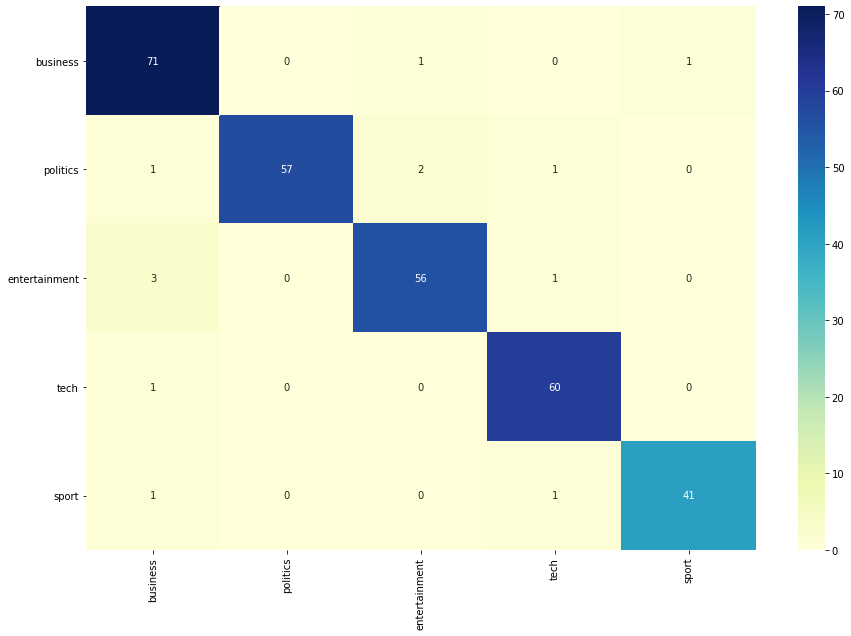

In [22]:
%matplotlib inline
import seaborn as sn
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(test_data['Category'], predictions)
conf_matrix_df = pd.DataFrame(conf_matrix, 
                              index=['business', 'politics', 'entertainment', 'tech', 'sport'], 
                              columns=['business', 'politics', 'entertainment', 'tech', 'sport'])

plt.figure(figsize=(15, 10))
sn.heatmap(conf_matrix_df, annot=True, vmin=0, vmax=conf_matrix.max(), fmt='d', cmap="YlGnBu")
plt.yticks(rotation=0)
plt.xticks(rotation=90)

Concluimos que nuestro clasificador es muy bueno ya que tiene un 0.96 en las tres medidas de media, un valor elevado para un clasificador. Vemos que, por ejemplo, la precisión en los textos de política es del 100% por lo que el clasificador es completamente fiable en el caso en el que clasifique a una noticia como política. El resto de categorías tienen también valores cercanos al uno.

A continuación, vamos a entrenar un clasificador kNN con esta vectorización y la configuración por defecto.

In [23]:
from sklearn import neighbors
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report

In [24]:
knn_classifier = neighbors.KNeighborsClassifier()
knn_classifier.fit(train_preprocessed, train_data['Category'])

knn_train_predictions = knn_classifier.predict(train_preprocessed)
knn_test_predictions = knn_classifier.predict(test_preprocessed)

print("k-NN, porcentaje de aciertos en entrenamiento:", 
      np.mean(knn_train_predictions == train_data['Category']))
print("k-NN, porcentaje de aciertos en test:", 
      np.mean(knn_test_predictions == test_data['Category']))

k-NN, porcentaje de aciertos en entrenamiento: 0.959731543624161
k-NN, porcentaje de aciertos en test: 0.9295302013422819


In [25]:
predictions = knn_classifier.predict(test_preprocessed)
print(classification_report(test_data['Category'], predictions, 
                            target_names=['business', 'politics', 'entertainment', 'tech', 'sport']))

               precision    recall  f1-score   support

     business       0.91      0.93      0.92        73
     politics       0.95      0.89      0.92        61
entertainment       0.92      0.93      0.93        60
         tech       0.94      0.98      0.96        61
        sport       0.95      0.91      0.93        43

     accuracy                           0.93       298
    macro avg       0.93      0.93      0.93       298
 weighted avg       0.93      0.93      0.93       298



(array([0.5, 1.5, 2.5, 3.5, 4.5]),
 [Text(0.5, 0, 'business'),
  Text(1.5, 0, 'politics'),
  Text(2.5, 0, 'entertainment'),
  Text(3.5, 0, 'tech'),
  Text(4.5, 0, 'sport')])

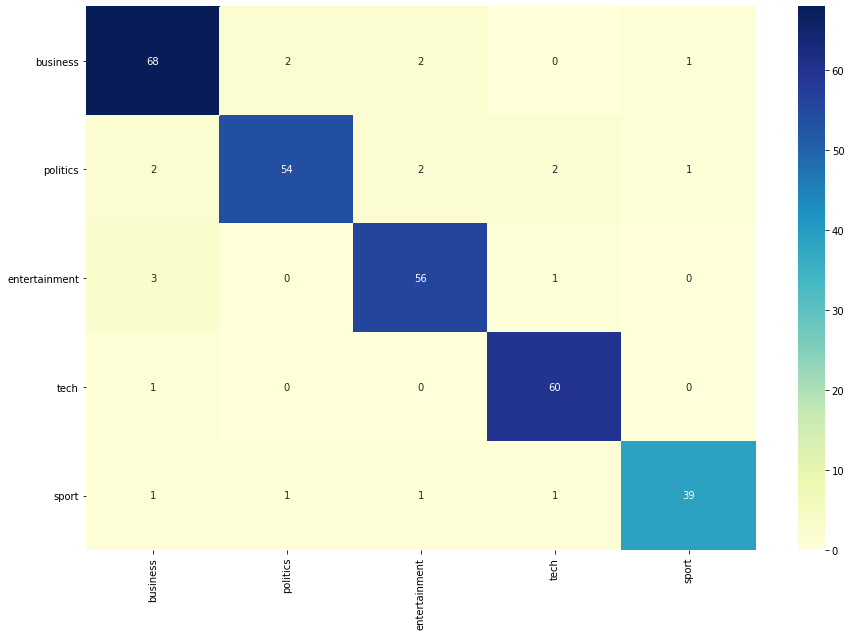

In [26]:
conf_matrix = confusion_matrix(test_data['Category'], predictions)
conf_matrix_df = pd.DataFrame(conf_matrix, 
                              index=['business', 'politics', 'entertainment', 'tech', 'sport'], 
                              columns=['business', 'politics', 'entertainment', 'tech', 'sport'])

plt.figure(figsize=(15, 10))
sn.heatmap(conf_matrix_df, annot=True, vmin=0, vmax=conf_matrix.max(), fmt='d', cmap="YlGnBu")
plt.yticks(rotation=0)
plt.xticks(rotation=90)

Vemos que el clasificador KNN es ligeramente peor que el anterior. Esto se debe a que sufre de la maldición de la dimensionalidad: las variables son del orden de millares, principal causa de la dimensión tan elevada, y, además, las palabras no suelen repetirse. 
Aún así, tiene valores de precisión y exhaustividad más que aceptables (rondando el 0.9), por lo que consideramos como fiable también a este clasificador. 

## 3) Representación basada en word-embeddings

La segunda vectorización que vamos a usar representará los mensajes usando word-embeddings. Cada documento se representará como el vector que resulta de promediar los embeddings de cada una de sus palabras. Al igual que en el apartado anterior, usaremos monogramas y las _stop words_ que vienen configuradas por defecto para el inglés. Recuerda usar como vocabulario para vectorizar el vocabulario del fichero con las word-embeddings. 

Entrena un clasificador Naive Bayes Gaussiano (el Multinomial no admite valores negativos que sí aparecen en los embeddings). Analiza el error por clase y dibuja la matriz de confusión.

Entrena otro clasificador kNN con la nueva vectorización y la configuración por defecto y analiza su error.

Cargamos y traducimos el fichero de la words-embeddings de Glove al formato word2vec, que reconoce Gensim, que en realidad es prácticamente idéntico al que ya tenemos.

In [27]:
!pip install gensim
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors

# Traducimos el fichero glove a un fichero con formato word2vec
glove_file = 'glove.6B.50d.txt'
#glove_file = '/content/drive/MyDrive/Asignaturas/IA/IA2_21-22/Material/PLN/tmp/practica/Parte 1/glove.6B.50d.txt'

# Gensim 3 requiere hacerlo en varios pasos
#word2vec_file = 'glove.6B.50d.txt.word2vec'
#glove2word2vec(glove_file, word2vec_file)
#model = KeyedVectors.load_word2vec_format(word2vec_file, binary=False)

# Gensim 4 puede transformar de glove a word2vec directamente
model = KeyedVectors.load_word2vec_format(glove_file, binary=False, no_header=True)

Creamos un vocabulario con todas las palabras del word-embeddings

In [28]:
we_vocabulary = list(model.key_to_index.keys())

print(we_vocabulary[0:10])

['the', ',', '.', 'of', 'to', 'and', 'in', 'a', '"', "'s"]


In [29]:
# En vocabulary le pasamos el de la word-embedding, ponemos que pase los tokens a minusculas 
# Si ponemos binary a False coge frecuencias y si está en true presencia en modo binario
vectorizerwe = CountVectorizer(vocabulary = we_vocabulary,stop_words='english', binary = False)

# Tomamos los textos del conjunto de entrenamiento y los transformamos en 
# una matriz de datos (palabras) según el diccionario estándar
train_vector_datawe=vectorizerwe.fit_transform(train_data['Text'])
train_vector_datawe

<1192x400000 sparse matrix of type '<class 'numpy.int64'>'
	with 169636 stored elements in Compressed Sparse Row format>

Lo que devuelve `vectorizer.fit_transform()` es una matriz dispersa ([scipy.sparse.csr_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html)).

Necesitamos saber para cada documento qué términos (índices) están presentes (valor distinto de cero).

In [30]:
from scipy.sparse import find


def create_doc_embedding (doc_matrix_word_freq, keyedvectors):
    """
    create_doc_embedding creates a doc-embedding matrix where rows are the 
    documents and columns are the dimensions of the word-embedding. Each row r
    summarizes the vectors of the word-embeddings present in document r

    :param doc_matrix_word_freq: frequency matrix of the terms in each document
            It admits binary values, frequencies or weights.
            It admits the output of vectorizer.fit_transform
    :param keyedvectors: keyedvectors object from Gensim which has the 
            word-embedding information
    :return: returns the doc-embedding matrix that summarizes the 
             vector-embeddings of the words present in each document
    """ 

    
    num_docs, num_words= doc_matrix_word_freq.get_shape()

    # Creamos la matriz de documentos con tantas columnas como dimensiones tiene el we 
    doc_embed_matrix = np.zeros([num_docs,keyedvectors.vector_size])


    # Obtenemos los documentos
    docs, col, val = find(doc_matrix_word_freq)
    docs = np.unique(docs)

    # Para cada documento (esto se podrá hacer de forma más pythonica)
    for doc in docs:
      # Obtenemos las palabras presentes en el documento y su frecuencia
      row, words, frecs = find(doc_matrix_word_freq[doc,:])

      # Calculamos el vector medio para el documento
      # Para ello recuperamos los vectores del we presentes en el documento y 
      # los promediamos teniendo en cuenta su frecuencia
      count = 0
      for w,f in zip(words,frecs):
        doc_embed_matrix[doc,:] = doc_embed_matrix[doc,:] + (keyedvectors[w] * f)
        count = count +1
      doc_embed_matrix[doc,:] = doc_embed_matrix[doc,:]/count
    
      
    return doc_embed_matrix

In [31]:
doc_embed_matrix = create_doc_embedding(train_vector_datawe,model)
# contiene un vector "embedding" para cada documento
doc_embed_matrix

array([[ 0.15184353,  0.23212156, -0.18658831, ...,  0.14390812,
        -0.26510242,  0.39763524],
       [ 0.10988595,  0.2454965 ,  0.28276599, ...,  0.04349587,
         0.316787  , -0.13520244],
       [ 0.1033332 , -0.1054833 ,  0.56526239, ..., -0.0311638 ,
        -0.10769761,  0.07153345],
       ...,
       [-0.12443175,  0.1322332 ,  0.31281526, ..., -0.1056725 ,
        -0.0780379 ,  0.21207116],
       [ 0.17293664,  0.00675873,  0.01593481, ...,  0.41879221,
         0.15255979, -0.16684434],
       [ 0.05444651, -0.01190014,  0.13009308, ...,  0.3612351 ,
         0.26546411,  0.20610788]])

A continuación probamos el **NB Gaussiano**. 


In [32]:
from sklearn.naive_bayes import GaussianNB

gnb_classifier = GaussianNB()

gnb_classifier.fit(doc_embed_matrix, train_data['Category'])

GaussianNB()

Transformamos tambien los datos de test para probar el clasificador en los datos de prueba.

In [45]:
test_vector_datawe=vectorizerwe.fit_transform(test_data['Text'])
doc_test_embed_matrix = create_doc_embedding(test_vector_datawe,model)
doc_test_embed_matrix

array([[ 0.42321138,  0.1795468 ,  0.18902295, ..., -0.00895133,
        -0.19408507, -0.31516479],
       [-0.02952967,  0.00319127, -0.34733704, ..., -0.11835652,
         0.20811419, -0.27923777],
       [ 0.27468501,  0.28088513, -0.0322915 , ...,  0.36828946,
        -0.09288609, -0.0808704 ],
       ...,
       [ 0.14940373,  0.15584969, -0.02434964, ..., -0.23369227,
        -0.13647668,  0.12275208],
       [ 0.32119034,  0.20821959,  0.71244849, ...,  0.71060981,
        -0.23301065, -0.5088687 ],
       [ 0.38197859,  0.03350476,  0.33621044, ...,  0.2597901 ,
        -0.07746115,  0.10035202]])

In [47]:
gnb_train_predictions = gnb_classifier.predict(doc_embed_matrix)
gnb_test_predictions = gnb_classifier.predict(doc_test_embed_matrix)
print("Gaussian Naive Bayes, porcentaje de aciertos en entrenamiento:", np.mean(gnb_train_predictions == train_data['Category']))
print("Gaussian Naive Bayes, porcentaje de aciertos en test:", np.mean(gnb_test_predictions == test_data['Category']))

Gaussian Naive Bayes, porcentaje de aciertos en entrenamiento: 0.9404362416107382
Gaussian Naive Bayes, porcentaje de aciertos en test: 0.9161073825503355


Observamos un porcentaje de aciertos en entrenamiento del 94% y un 91% en test lo que es un porcentaje alto para nuestro clasificador pero comete bastantes fallos.

In [48]:
from sklearn.metrics import classification_report, confusion_matrix

# NOTA: Aquí elegimos analizar un determinado clasificador y sus predicciones 
# Por ejemplo el naive bayes
classifier= gnb_classifier
predictions = gnb_test_predictions

print(classification_report(test_data['Category'], predictions, 
                            target_names=['business', 'politics', 'entertainment', 'tech', 'sport']))

               precision    recall  f1-score   support

     business       0.92      0.90      0.91        73
     politics       0.95      0.90      0.92        61
entertainment       0.80      0.93      0.86        60
         tech       0.98      0.95      0.97        61
        sport       0.97      0.88      0.93        43

     accuracy                           0.92       298
    macro avg       0.92      0.91      0.92       298
 weighted avg       0.92      0.92      0.92       298



Observamos que la media de precision, recall y f1 es de 0.92, 0.91 y 0.92 respectivamente lo cual es un resultado alto para un clasificador pero mejorable. El uso de word-embeddings permite clasificar correctamente la mayoría de las noticias capturando la similitud entre los términos que se emplean en los textos, sin embargo, esto es una aproximación tosca ya que resume un documento en base a sus palabras y es muy susceptible al ruido. Vemos que la categoría tech es la que mejor precisión, recall y f1 tiene. Esto se puede deber a que las palabras técnicas en un texto de esa categoría son muy específicas y seguramente no aparezcan palabras similares en un texto de las otras cuatro categorías. Sin embargo, en el caso de business y politics, que tienen peores medidas, podría deberse a que los textos de esas categorías podrían tener más palabras relacionadas a pesar de que el tema del texto sea diferente. Por ejemplo, un texto de business puede ir sobre su CEO, su organización etc. Algo parecido podría pasar entre todas las categorías y por eso decimos que puede ser una aproximación tosca. Vemos que los textos de entretenimiento son los que peores valores tienen. Esto se puede deber a que seguramente sean textos de temas más variados dedicados a entretener y que utilicen palabras de todo tipo que puedan tener relación con las palabras de los textos de otra categoría.

(array([0.5, 1.5, 2.5, 3.5, 4.5]),
 [Text(0.5, 0, 'business'),
  Text(1.5, 0, 'politics'),
  Text(2.5, 0, 'entertainment'),
  Text(3.5, 0, 'tech'),
  Text(4.5, 0, 'sport')])

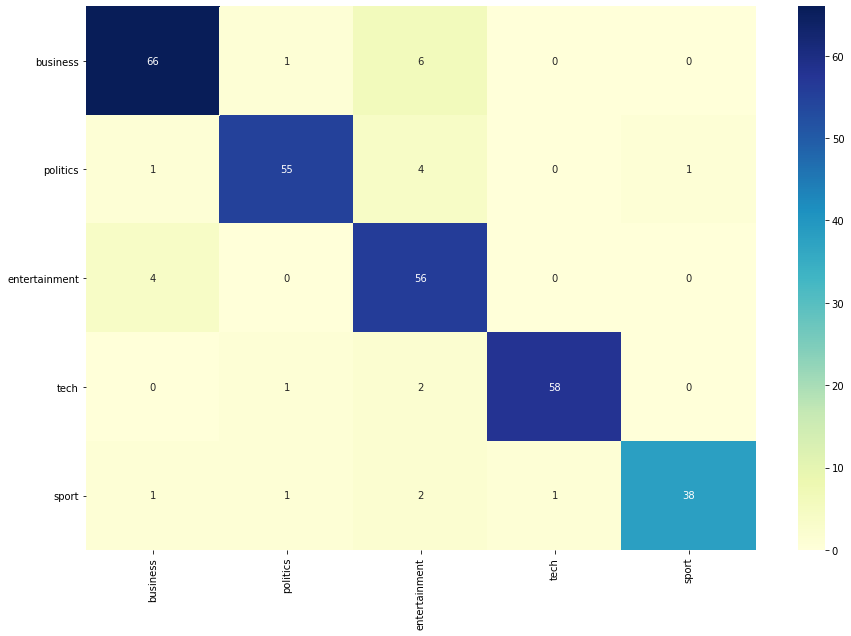

In [49]:
%matplotlib inline
import seaborn as sn
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(test_data['Category'], predictions)
conf_matrix_df = pd.DataFrame(conf_matrix, 
                              index=['business', 'politics', 'entertainment', 'tech', 'sport'], 
                              columns=['business', 'politics', 'entertainment', 'tech', 'sport'])

plt.figure(figsize=(15, 10))
sn.heatmap(conf_matrix_df, annot=True, vmin=0, vmax=conf_matrix.max(), fmt='d', cmap="YlGnBu")
plt.yticks(rotation=0)
plt.xticks(rotation=90)

Observamos en la matriz de confusión que por ejemplo, los textos de entretenimiento los confunde con todas las demás categorías. Esto se puede deber como hemos comentado antes a en un texto de entretenimiento seguramente se usen todo tipo de palabras dependiendo del tema en cuestión y por ello se pueden relacionar con textos de otra categoría que usen palabras relacionadas. Puede ocurrir lo mismo entre el resto de categorías dependiendo de las palabras que utilice cada texto pero observamos que de forma general nuestro clasificador funciona correctamente.

A continuación, vamos a entrenar un clasificador kNN con esta vectorización y la configuración por defecto.

In [50]:
knn_classifier = neighbors.KNeighborsClassifier()
knn_classifier.fit(doc_embed_matrix, train_data['Category'])

knn_train_predictions = knn_classifier.predict(doc_embed_matrix)
knn_test_predictionsWE = knn_classifier.predict(doc_test_embed_matrix)

print("k-NN, porcentaje de aciertos en entrenamiento:", 
      np.mean(knn_train_predictions == train_data['Category']))
print("k-NN, porcentaje de aciertos en test:", 
      np.mean(knn_test_predictionsWE == test_data['Category']))

k-NN, porcentaje de aciertos en entrenamiento: 0.9773489932885906
k-NN, porcentaje de aciertos en test: 0.9630872483221476


In [51]:
predictions = knn_classifier.predict(doc_test_embed_matrix)
print(classification_report(test_data['Category'], predictions, 
                            target_names=['business', 'politics', 'entertainment', 'tech', 'sport']))

               precision    recall  f1-score   support

     business       0.97      0.95      0.96        73
     politics       0.97      0.95      0.96        61
entertainment       0.94      0.98      0.96        60
         tech       0.98      0.98      0.98        61
        sport       0.95      0.95      0.95        43

     accuracy                           0.96       298
    macro avg       0.96      0.96      0.96       298
 weighted avg       0.96      0.96      0.96       298



In [52]:
test_data['Category'].value_counts()


business         73
entertainment    61
sport            61
politics         60
tech             43
Name: Category, dtype: int64

(array([0.5, 1.5, 2.5, 3.5, 4.5]),
 [Text(0.5, 0, 'business'),
  Text(1.5, 0, 'politics'),
  Text(2.5, 0, 'entertainment'),
  Text(3.5, 0, 'tech'),
  Text(4.5, 0, 'sport')])

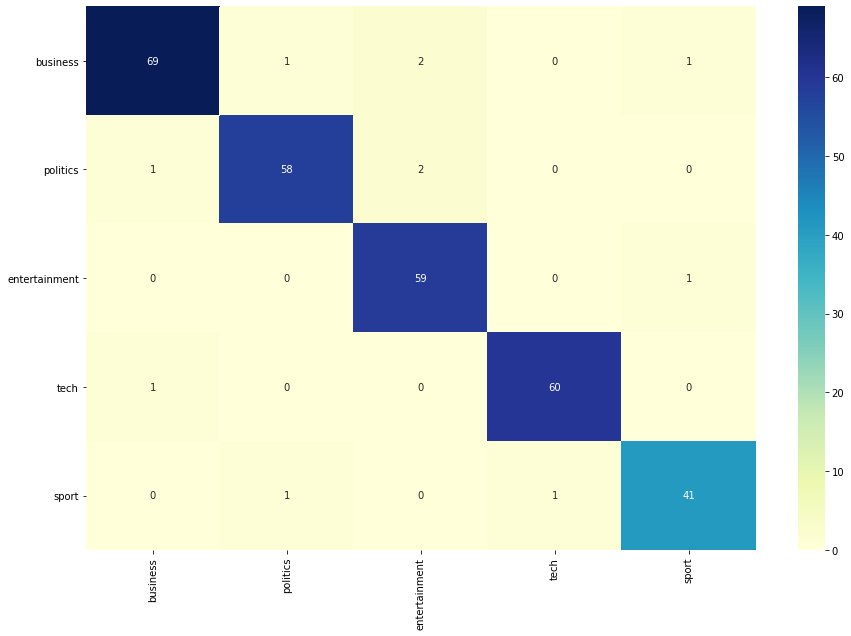

In [53]:
conf_matrix = confusion_matrix(test_data['Category'], predictions)
conf_matrix_df = pd.DataFrame(conf_matrix, 
                              index=['business', 'politics', 'entertainment', 'tech', 'sport'], 
                              columns=['business', 'politics', 'entertainment', 'tech', 'sport'])

plt.figure(figsize=(15, 10))
sn.heatmap(conf_matrix_df, annot=True, vmin=0, vmax=conf_matrix.max(), fmt='d', cmap="YlGnBu")
plt.yticks(rotation=0)
plt.xticks(rotation=90)

## 4) Análisis comparativo final

Hemos entrenado dos clasificadores usando dos vectorizaciones diferentes de los datos. Compara la tasa de acierto de todos ellos y explica a qué crees que se deben las diferencias.

Busca un mensaje mal clasificado por el Naive Bayes con vectorización de frecuencias y otro mal clasificado por el k-NN con Word-embeddings. Analiza los vectores de términos de dichos mensajes e intenta razonar por qué ha sido clasificado erróneamente.

Para el Naive Bayes con vectorización de frecuencias, elige dos clases donde el clasificador no haya funcionado bien y analiza las palabras más relevantes para clasificar una noticia como de dichas clases. Razona si lo que ves crees que influye en la posible confusión a la hora de clasificar entre dichas clases.

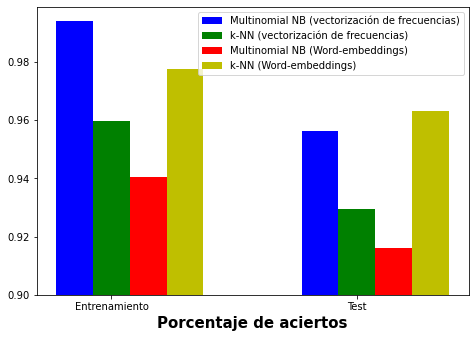

In [54]:
import numpy as np
import matplotlib.pyplot as plt

X = np.arange(2)
barWidth = 0.15
plotBottom = 0.9

data = [[0.9941275167785235 - plotBottom,  0.9563758389261745 - plotBottom], 
        [0.959731543624161 - plotBottom, 0.9295302013422819 - plotBottom],
        [0.9404362416107382 - plotBottom, 0.9161073825503355 - plotBottom],
        [0.9773489932885906 - plotBottom, 0.9630872483221476 - plotBottom]]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, data[0], bottom = plotBottom, color = 'b', width = barWidth, 
       label = 'Multinomial NB (vectorización de frecuencias)')
ax.bar(X + barWidth, data[1], bottom = plotBottom, color = 'g', width = barWidth, 
       label = 'k-NN (vectorización de frecuencias)')
ax.bar(X + 2*barWidth, data[2], bottom = plotBottom, color = 'r', width = barWidth, 
       label = 'Multinomial NB (Word-embeddings)')
ax.bar(X + 3*barWidth, data[3], bottom = plotBottom, color = 'y', width = barWidth, 
       label = 'k-NN (Word-embeddings)')

# Adding Xticks
plt.xlabel('Porcentaje de aciertos', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(2)], ['Entrenamiento', 'Test'])
 
plt.legend()
plt.show()


Como podemos observar en esta gráfica, el clasificador Multinomial Naive Bayes funciona casi a la perfección con la vectorización de frecuencias: aprende cómo de frecuente es cada clase y cómo de frecuente es que una palabra ocurra en cada clase. A la hora de clasificar un texto nuevo, en este caso sólo el 20% de los dados, el clasificador estima la probabilidad de que pertenezca a cada una de las clases y elige la más alta. Así pues, podemos suponer que las palabras clave elegidas por el algoritmo sí que ayudan enormemente a la clasificación de cada texto, siendo entonces palabras temáticas muy específicas, que en general, no se encuentran en textos de otros contenidos. Sin embargo, no es tan fiable al utilizar word-embeddings.

Por otro lado, justo lo contrario pasa para el clasificador k-NN, que manifiesta una clara mejora al utilizar Word-Embeddings. Esto tiene sentido, puesto que con word-embeddings, las palabras relacionadas entre sí estarán más cerca en el espacio, facilitando el trabajo al k-NN (el cual toma los K vecinos más cercanos de una palabra). Con vectorización de frecuencias, sin embargo, sufre mucho, debido a la alta dimensionalidad del espacio.   

Ahora, buscamos un mensaje mal clasificado por el Naive Bayes con vectorización de frecuencias, y analizamos su vector de términos. 

In [55]:
errorMNB = 0
while (mnb_test_predictions[errorMNB] == test_data.values[errorMNB][1]):
    errorMNB = errorMNB + 1
    
write_terms(feature_names, test_data['Text'].values , test_vector_data, errorMNB)
print('PREDICCIÓN \n Este texto ha sido clasificado como ', mnb_test_predictions[errorMNB],
      ' cuando en realidad es ', test_data.values[errorMNB][1])

Mensaje 0 : tv show unites angolan families angolan families who are attempting to track each other down  after being separated by nearly 30 years of war  are succeeding thanks to a hugely popular tv show.  meeting point has become one of tv angola s most watched programmes  and has reunited hundreds of families. it runs daily  not only on the television but also on the radio. every friday  hundreds of people gather in luanda s independence square to record a message in front of the tv cameras  in the hope that a lost relative will see it. many relatives have been reunited on air.  at the beginning there was an absolute explosion - huge  huge crowds   sergio gera  the programme s chief co-ordinator  told bbc world service s assignment programme.  now things are a little calmer  there are slightly less people - but  after two and a half years of broadcasting  there are still a lot of people going.   the media in the southern african country  twice the size of france  has been gripped by

Esta noticia en cuestión nos describe un programa de televisión y radio, por lo que está inicialmente clasificada como entretenimiento. El error se debe a que el propósito de dicho programa es que familias angoleñas que tengan familiares en paradero desconocido (por la guerra) puedan buscarlos vía este medio. 
Vemos que en el vector de términos aparecen pocos relacionados con entertainment, como 'television', 'watched', 'broadcasts', ... y sin embargo, otros términos sobre las relaciones internacionales, países, guerras, etc, hacen mayor aparición. Por tanto, las palabras relacionadas con la política tienen un mayor peso (aparecen con mayor frecuencia), y por tanto nuestro clasificador la cataloga como politics. 

In [60]:
errorKNN = 1
while (knn_test_predictionsWE[errorKNN] == test_data.values[errorKNN][1]):
    errorKNN = errorKNN + 1
    
write_terms(feature_names, test_data['Text'].values , test_vector_data, errorKNN)
print('PREDICCIÓN \n Este texto ha sido clasificado como ', knn_test_predictionsWE[errorKNN],
      ' cuando en realidad es ', test_data.values[errorKNN][1])

Mensaje 26 : man auctions ad space on forehead a 20-year-old us man is selling advertising space on his forehead to the highest bidder on website ebay.  andrew fisher  from omaha  nebraska  said he would have a non-permanent logo or brand name tattooed on his head for 30 days.  the way i see it i m selling something i already own; after 30 days i get it back   he told the bbc today programme. mr fisher has received 39 bids so far  with the largest bid currently at more than $322 (£171).  the winner will be able to send me a tattoo or have me go to a tattoo parlour and get a temporary ink tattoo on my forehead and this will be something they choose  a company name or domain name  perhaps their logo   he told the radio 4 programme.  on the online auction  mr fisher describes himself as an  average american joe  give or take . his sales pitch adds:  take advantage of this radical advertising campaign and become a part of history.  mr fisher said that while he would accept any brand name o

Al leer este texto, vemos que aunque está clasificado como una noticia de sobre tecnología, ya que habla sobre un joven que decide subastar su frente como espacio publicitario por eBay, una plataforma online. Sin embargo, está estrechamente relacionada con otros. Por ejemplo, el clasificador kNN con Word Embeddings lo ha confudido con uno sobre entretenimiento, debido a la alta cantidad de palabras que encontramos que pertenecen a esa temática (bbc, media, radio, programme...) al relatar sus intenciones a los medios de comunicación. También podría haberse confundido con un tema sobre negocios, ya que el propio protagonista está, por decirlo así, "montando" su propio negocio, al intentar lucrarse del alquiler de una parte de su cuerpo. 

Para el Naive Bayes con vectorización de frecuencias, elige dos clases donde el clasificador no haya funcionado bien y analiza las palabras más relevantes para clasificar una noticia como de dichas clases. Razona si lo que ves crees que influye en la posible confusión a la hora de clasificar entre dichas clases.

In [61]:
"data -> train_data.values"
"tfid -> train_preprocessed.toarray()"
"category -> 'entertainment', 'sport', ..."
"Palabras y su TF/IDF para los documentos de la categoría category"
def relevant_words(data, tfid, category):
    s = [0]*tfid.shape[1]
    for i in range(len(data)):
        if data[i][1] == category:
            s = np.add(s, tfid[i])      
            
    dfCAT = pd.DataFrame({'words': feature_names, 'TF/IDF': s})
    relevant = dfCAT.sort_values(by = 'TF/IDF').tail(30).copy()
    return relevant

In [64]:
rENT = relevant_words(train_data.values, train_preprocessed.toarray(), 'entertainment')
rBUS = relevant_words(train_data.values, train_preprocessed.toarray(), 'business')
print("Las 30 palabras más relevantes para la categoría de entretenimiento son \n ", rENT)
print("\n ------------------------------- \n")
print("Las 30 palabras más relevantes para la categoría de business son \n ", rBUS)

Las 30 palabras más relevantes para la categoría de entretenimiento son 
              words     TF/IDF
13440        movie   3.039772
13890  nominations   3.088809
10497    including   3.095736
17933       series   3.111109
3303           box   3.237462
21907          won   3.288234
18999        stars   3.302703
13765          new   3.428683
6372      director   3.492223
1247       actress   3.668560
20701           uk   3.716897
18320       singer   3.918576
4720        comedy   3.978966
1546         album   3.993385
13989       number   4.063474
8110      festival   4.106210
20650           tv   4.329318
22087         year   4.621048
14325        oscar   4.630873
4211         chart   4.736755
8184         films   4.803119
1245         actor   4.895865
18990         star   4.961670
2376         award   4.975595
2520          band   5.043231
2379        awards   5.736451
17445         said   6.014716
13533        music   6.173654
2883          best   8.435543
8177          film  15.445

Hemos elegido las categorías de entretenimiento y negocios para compararse, ya que son las dos dónde peor ha funcionado el clasificador MNB con vectorización de frecuencias. Sin embargo, al ver las 30 palabras más relevantes para cada una de las categorías (es decir, las palabras que mayor TF/IDF tienen en los documentos de cada categoría), las únicas palabras que aparecen en ambas listas son 'new', 'year' y 'said'; no vemos ninguna repetición de algún verbo, sustantivo o adjetivo de claro significado temático. 
Así pues, y con estos datos, no podemos concluir con precisión el porqué la confusión del clasificador entre estas dos categorías. 